## Import all the necessary libraries

In [51]:
import csv
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm 
from sklearn.preprocessing import FunctionTransformer
import itertools    
from sklearn.metrics import mean_absolute_percentage_error

## Load the keys to query the data. This step is omitted for Fall 2022 Hack 

In [2]:
import os
BIGQUERY_PROJECT = 'cloud-test-ironhacks'
BIGQUERY_KEYPATH = 'cloud-test-ironhacks-c1010c49a602.json'

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = BIGQUERY_KEYPATH
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

## Query the data and see how they look like

In [3]:
query = """
SELECT * FROM `cloud-test-ironhacks.dwd_data.suppression_remove`

"""

query_job = bigquery_client.query(query)
data = query_job.to_dataframe()
data = data[data['uu_id'].notnull() & data['total_claims'].notnull()]
data 

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
59023,9bee42b55f891413ae7fac2d9d89280a,20210102.0,1.0,18003.0,100.0,"Census Tract 1, Allen County, Indiana",30.0,0.0,NaN,NaN,...,10.0,20.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,24.0
59026,9bee42b55f891413ae7fac2d9d89280a,20210109.0,2.0,18003.0,100.0,"Census Tract 1, Allen County, Indiana",51.0,NaN,NaN,25.0,...,22.0,29.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,42.0
59028,9bee42b55f891413ae7fac2d9d89280a,20210116.0,3.0,18003.0,100.0,"Census Tract 1, Allen County, Indiana",39.0,0.0,0.0,NaN,...,16.0,23.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,27.0
59029,9bee42b55f891413ae7fac2d9d89280a,20210123.0,4.0,18003.0,100.0,"Census Tract 1, Allen County, Indiana",36.0,NaN,NaN,16.0,...,13.0,23.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,28.0
59030,9bee42b55f891413ae7fac2d9d89280a,20210130.0,5.0,18003.0,100.0,"Census Tract 1, Allen County, Indiana",49.0,0.0,NaN,30.0,...,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210819,20f6ad2e745b760f4d67491c4c9f2881,20210807.0,32.0,18127.0,990000.0,"Census Tract 9900, Porter County, Indiana",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210820,20f6ad2e745b760f4d67491c4c9f2881,20210814.0,33.0,18127.0,990000.0,"Census Tract 9900, Porter County, Indiana",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210821,20f6ad2e745b760f4d67491c4c9f2881,20210821.0,34.0,18127.0,990000.0,"Census Tract 9900, Porter County, Indiana",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210822,20f6ad2e745b760f4d67491c4c9f2881,20210828.0,35.0,18127.0,990000.0,"Census Tract 9900, Porter County, Indiana",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
data = data.sort_values('week_number')
data

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
59023,9bee42b55f891413ae7fac2d9d89280a,20210102.0,1.0,18003.0,100.0,"Census Tract 1, Allen County, Indiana",30.0,0.0,NaN,NaN,...,10.0,20.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,24.0
164680,e778971fa9d6b706d93be8ef16551417,20220101.0,1.0,18109.0,510701.0,"Census Tract 5107.01, Morgan County, Indiana",15.0,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
164679,e778971fa9d6b706d93be8ef16551417,20210102.0,1.0,18109.0,510701.0,"Census Tract 5107.01, Morgan County, Indiana",21.0,0.0,NaN,14.0,...,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN
164578,731ddb089399afebca516d0a8a23e22e,20220101.0,1.0,18109.0,510600.0,"Census Tract 5106, Morgan County, Indiana",25.0,0.0,NaN,15.0,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
164577,731ddb089399afebca516d0a8a23e22e,20210102.0,1.0,18109.0,510600.0,"Census Tract 5106, Morgan County, Indiana",49.0,0.0,NaN,25.0,...,17.0,32.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154348,8d4a78dc3956df8b087cbd29b454c5de,20211225.0,52.0,18089.0,43202.0,"Census Tract 432.02, Lake County, Indiana",17.0,0.0,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN
149170,932a58530abff8a48558e2a15639d453,20211225.0,52.0,18091.0,41500.0,"Census Tract 415, LaPorte County, Indiana",23.0,0.0,0.0,10.0,...,NaN,19.0,NaN,0.0,0.0,NaN,NaN,0.0,0.0,19.0
123558,618bd975f55a022bd54daf828c1f7ce5,20211225.0,52.0,18097.0,330500.0,"Census Tract 3305, Marion County, Indiana",30.0,0.0,NaN,13.0,...,16.0,14.0,0.0,0.0,0.0,21.0,NaN,0.0,NaN,NaN
133028,04771ff1eb844f33d1e5d350c74cba29,20211225.0,52.0,18097.0,357300.0,"Census Tract 3573, Marion County, Indiana",10.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN


## Cumulate the data according to the week_number. 

In [5]:
df = data.groupby(['week_number']).total_claims.sum().groupby(level=0).cumsum().reset_index()
df

,week_number,total_claims
0,1.0,80409.0
1,2.0,146069.0
2,3.0,97335.0
3,4.0,78933.0
4,5.0,93236.0
5,6.0,85722.0
6,7.0,81699.0
7,8.0,79633.0
8,9.0,80513.0
9,10.0,17876.0


## Plot the overall data to see how the trend looks like. 

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='week_number', ylabel='total_claims'>

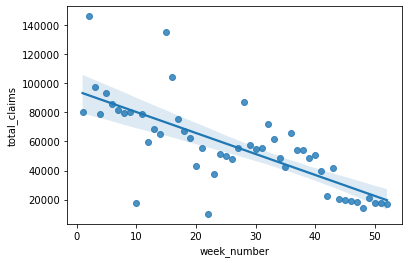

In [6]:
sns.regplot(df['week_number'], df['total_claims'])

## Start performing predictions on the overall data without the granularity from uu_id

> We do this primarily to decide if we should go with Linear Regression or Lag Regression. Note there are many ways to forecast which model might work better. 

In [7]:
X = df['week_number'].values.reshape(-1,1)
y = df['total_claims'].values.reshape(-1,1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.04, random_state = 0)

In [9]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression()

In [10]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

[95682.73793746]
[[-1483.55362505]]


In [11]:
y_pred = regressor.predict(X_test)

In [12]:
outcome = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
outcome

,Actual,Predicted
0,57881.0,52659.682811
1,54321.0,39307.700186
2,59368.0,77880.094437


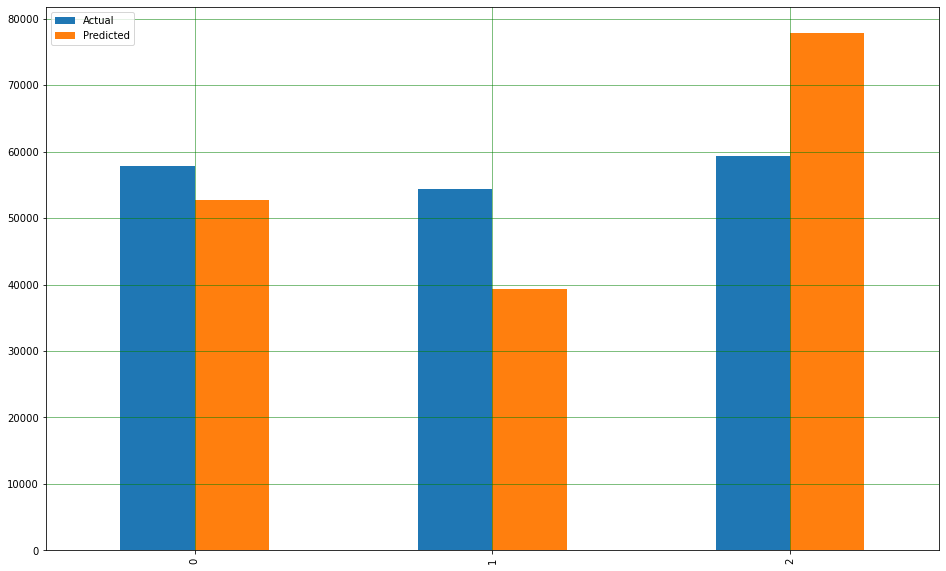

In [13]:
outcome = outcome.head(25)
outcome.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [14]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 12915.570480035238
Mean Squared Error: 198452988.31407133
Root Mean Squared Error: 14087.334322506558


## Start modeling with Lag Regression 

In [15]:
df['lag'] = df['total_claims'].shift(1).dropna()
df

,week_number,total_claims,lag
0,1.0,80409.0,NaN
1,2.0,146069.0,80409.0
2,3.0,97335.0,146069.0
3,4.0,78933.0,97335.0
4,5.0,93236.0,78933.0
5,6.0,85722.0,93236.0
6,7.0,81699.0,85722.0
7,8.0,79633.0,81699.0
8,9.0,80513.0,79633.0
9,10.0,17876.0,80513.0


In [16]:
X = df['lag'].dropna()
y = df['total_claims']
y, X = y.align(X, join='inner')  # drop corresponding values in target
X

1      80409.0
2     146069.0
3      97335.0
4      78933.0
5      93236.0
6      85722.0
7      81699.0
8      79633.0
9      80513.0
10     17876.0
11     79149.0
12     59368.0
13     68642.0
14     65153.0
15    135245.0
16    104336.0
17     75181.0
18     67122.0
19     62306.0
20     42947.0
21     55762.0
22     10064.0
23     37841.0
24     51552.0
25     50306.0
26     48232.0
27     55505.0
28     87135.0
29     57881.0
30     54890.0
31     55256.0
32     72087.0
33     61858.0
34     48390.0
35     42264.0
36     65988.0
37     54274.0
38     54321.0
39     48581.0
40     50807.0
41     39436.0
42     22482.0
43     41570.0
44     20470.0
45     19736.0
46     19262.0
47     18081.0
48     14153.0
49     21019.0
50     17884.0
51     17643.0
Name: lag, dtype: float64

In [17]:
X = X.values.reshape(-1,1)
y = y.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.04, random_state = 0)

regressor = LinearRegression().fit(X,y)

In [18]:
#To retrieve the intercept:
print(regressor.intercept_)

#For retrieving the slope:
print(regressor.coef_)

[18006.50827857]
[[0.66337784]]


In [19]:
y_pred = regressor.predict(X_test)

In [20]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
0,55256.0,54419.317803
1,68642.0,57389.923761
2,59368.0,70512.200773


In [21]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 7744.319736462957
Mean Squared Error: 83834155.88676928
Root Mean Squared Error: 9156.099381656431


## Now we decided we should use Linear Regression due to the better RMSE value. 

## Sort the dataframe 

> Sort the dataframe according to week_number so that we can use test_train_split directly on the top portion of the dataframe as the training set by setting stratify = False and shuffle = False. There are many ways to doing this. 

In [22]:
data = data.sort_values('week_number')
data

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
59023,9bee42b55f891413ae7fac2d9d89280a,20210102.0,1.0,18003.0,100.0,"Census Tract 1, Allen County, Indiana",30.0,0.0,NaN,NaN,...,10.0,20.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,24.0
96800,a9bca8b45ff64eb750a37815fe41eab3,20210102.0,1.0,18167.0,1800.0,"Census Tract 18, Vigo County, Indiana",30.0,0.0,NaN,16.0,...,13.0,17.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,25.0
106324,79f498ddd9d03b81d9aa69a7285c77d1,20210102.0,1.0,18089.0,21400.0,"Census Tract 214, Lake County, Indiana",43.0,0.0,NaN,25.0,...,20.0,23.0,0.0,0.0,0.0,19.0,NaN,0.0,NaN,15.0
106425,4e3514e61fd5e471e005f8c17f9e0941,20210102.0,1.0,18089.0,21500.0,"Census Tract 215, Lake County, Indiana",23.0,0.0,NaN,15.0,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,14.0
97004,18792af8852f8d0c77371eb582a87ef9,20220101.0,1.0,18039.0,1802.0,"Census Tract 18.02, Elkhart County, Indiana",15.0,0.0,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94971,2cdd008e5ed8dda4500abddebdded776,20211225.0,52.0,18095.0,1600.0,"Census Tract 16, Madison County, Indiana",11.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
112410,b134145ba25768f028f9f852973ee227,20211225.0,52.0,18163.0,3000.0,"Census Tract 30, Vanderburgh County, Indiana",16.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
64397,cb304c84e572423d939db1dbb2009609,20211225.0,52.0,18089.0,10201.0,"Census Tract 102.01, Lake County, Indiana",42.0,0.0,NaN,28.0,...,25.0,17.0,0.0,0.0,0.0,33.0,NaN,0.0,NaN,NaN
124374,c5ec684089ebc4b152d4bc616685ad1d,20211225.0,52.0,18097.0,331000.0,"Census Tract 3310, Marion County, Indiana",40.0,0.0,NaN,25.0,...,14.0,26.0,0.0,0.0,0.0,34.0,NaN,0.0,NaN,NaN


## Function to print the dataframe according to the desired output format. 

In [23]:
def printexcel(result, filename):
    frame = pd.DataFrame(list(result.items()), columns=['uu_id','total_claims'])
    frame['total_claims'] =  frame['total_claims'].apply(lambda x: str(x).replace('[','').replace(']',''))
    frame['total_claims'] = frame['total_claims'].astype(float)
    frame.to_csv(filename, index=False)

## Function to predict week 52. 

In [24]:
week52 = data[data['week_number'] == 52]
week52

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
74676,f803d86b888113bb51a9ee32c499217d,20211225.0,52.0,18003.0,10900.0,"Census Tract 109, Allen County, Indiana",20.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
78939,fa339582e0e0e47497dbe039bb00b19f,20211225.0,52.0,18057.0,110700.0,"Census Tract 1107, Hamilton County, Indiana",11.0,0.0,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
149872,e8110fa2ab61007365cb825240af25dd,20211225.0,52.0,18089.0,41800.0,"Census Tract 418, Lake County, Indiana",34.0,NaN,NaN,18.0,...,12.0,22.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,19.0
133334,33c4302fb88e93ea520a346fe2853209,20211225.0,52.0,18097.0,357600.0,"Census Tract 3576, Marion County, Indiana",38.0,NaN,NaN,21.0,...,19.0,19.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,22.0
118789,c0391823af85ef75df9d031878d35b5d,20211225.0,52.0,18097.0,320204.0,"Census Tract 3202.04, Marion County, Indiana",19.0,0.0,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94971,2cdd008e5ed8dda4500abddebdded776,20211225.0,52.0,18095.0,1600.0,"Census Tract 16, Madison County, Indiana",11.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
112410,b134145ba25768f028f9f852973ee227,20211225.0,52.0,18163.0,3000.0,"Census Tract 30, Vanderburgh County, Indiana",16.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
64397,cb304c84e572423d939db1dbb2009609,20211225.0,52.0,18089.0,10201.0,"Census Tract 102.01, Lake County, Indiana",42.0,0.0,NaN,28.0,...,25.0,17.0,0.0,0.0,0.0,33.0,NaN,0.0,NaN,NaN
124374,c5ec684089ebc4b152d4bc616685ad1d,20211225.0,52.0,18097.0,331000.0,"Census Tract 3310, Marion County, Indiana",40.0,0.0,NaN,25.0,...,14.0,26.0,0.0,0.0,0.0,34.0,NaN,0.0,NaN,NaN


In [25]:
data

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
59023,9bee42b55f891413ae7fac2d9d89280a,20210102.0,1.0,18003.0,100.0,"Census Tract 1, Allen County, Indiana",30.0,0.0,NaN,NaN,...,10.0,20.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,24.0
96800,a9bca8b45ff64eb750a37815fe41eab3,20210102.0,1.0,18167.0,1800.0,"Census Tract 18, Vigo County, Indiana",30.0,0.0,NaN,16.0,...,13.0,17.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,25.0
106324,79f498ddd9d03b81d9aa69a7285c77d1,20210102.0,1.0,18089.0,21400.0,"Census Tract 214, Lake County, Indiana",43.0,0.0,NaN,25.0,...,20.0,23.0,0.0,0.0,0.0,19.0,NaN,0.0,NaN,15.0
106425,4e3514e61fd5e471e005f8c17f9e0941,20210102.0,1.0,18089.0,21500.0,"Census Tract 215, Lake County, Indiana",23.0,0.0,NaN,15.0,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,14.0
97004,18792af8852f8d0c77371eb582a87ef9,20220101.0,1.0,18039.0,1802.0,"Census Tract 18.02, Elkhart County, Indiana",15.0,0.0,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94971,2cdd008e5ed8dda4500abddebdded776,20211225.0,52.0,18095.0,1600.0,"Census Tract 16, Madison County, Indiana",11.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
112410,b134145ba25768f028f9f852973ee227,20211225.0,52.0,18163.0,3000.0,"Census Tract 30, Vanderburgh County, Indiana",16.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
64397,cb304c84e572423d939db1dbb2009609,20211225.0,52.0,18089.0,10201.0,"Census Tract 102.01, Lake County, Indiana",42.0,0.0,NaN,28.0,...,25.0,17.0,0.0,0.0,0.0,33.0,NaN,0.0,NaN,NaN
124374,c5ec684089ebc4b152d4bc616685ad1d,20211225.0,52.0,18097.0,331000.0,"Census Tract 3310, Marion County, Indiana",40.0,0.0,NaN,25.0,...,14.0,26.0,0.0,0.0,0.0,34.0,NaN,0.0,NaN,NaN


In [26]:
common = set(data['uu_id']).intersection(week52['uu_id'])

out = pd.concat([data[data['uu_id'].isin(common)], week52[week52['uu_id'].isin(common)]])
out = out.sort_values('week_number')
out

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
106425,4e3514e61fd5e471e005f8c17f9e0941,20210102.0,1.0,18089.0,21500.0,"Census Tract 215, Lake County, Indiana",23.0,0.0,NaN,15.0,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,14.0
170608,318f81c51dc1b03b38314b8035041f1b,20210102.0,1.0,18003.0,701.0,"Census Tract 7.01, Allen County, Indiana",61.0,NaN,NaN,34.0,...,16.0,45.0,0.0,0.0,NaN,17.0,0.0,0.0,NaN,38.0
166430,cc02fd217be91851d0064178536d1bb6,20210102.0,1.0,18167.0,600.0,"Census Tract 6, Vigo County, Indiana",25.0,0.0,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,19.0
74270,0266d733b0836fe9368cde5384d1c8f5,20210102.0,1.0,18003.0,10817.0,"Census Tract 108.17, Allen County, Indiana",51.0,0.0,NaN,NaN,...,30.0,NaN,NaN,0.0,NaN,12.0,NaN,0.0,NaN,29.0
162146,666c7361f0603c0cb4b783beddb796d8,20220101.0,1.0,18127.0,50704.0,"Census Tract 507.04, Porter County, Indiana",13.0,0.0,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134456,4084f9199d73deb5cf6dd200a5db1c80,20211225.0,52.0,18097.0,360301.0,"Census Tract 3603.01, Marion County, Indiana",19.0,0.0,NaN,10.0,...,NaN,NaN,0.0,0.0,0.0,12.0,NaN,NaN,NaN,NaN
133028,04771ff1eb844f33d1e5d350c74cba29,20211225.0,52.0,18097.0,357300.0,"Census Tract 3573, Marion County, Indiana",10.0,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN
120001,d3bf31d4fda5dd60330943a904ac5d5a,20211225.0,52.0,18097.0,321001.0,"Census Tract 3210.01, Marion County, Indiana",10.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
121625,c2e8e1c1da5aa1482049619b9f50efca,20211225.0,52.0,18097.0,322600.0,"Census Tract 3226, Marion County, Indiana",35.0,0.0,14.0,NaN,...,19.0,16.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0


## Get only week 52 data 

In [45]:
def regressionsquare(data, yvar, xvars):
    X_train, X_test, y_train, y_test = train_test_split(data[xvars], data[yvar], train_size=0.9999, random_state=42, shuffle=False, stratify=None)
    result = sm.OLS(y_train, X_train).fit()
    predictions = result.predict(52)
    return predictions
result = out.groupby('uu_id').apply(regressionsquare, 'total_claims', 'week_number')
print(result)

uu_id
0024b3c6293e38b01016693d728f424d    [50.231527278646645]
005be9532fd717dc36d4be318fd9ad25    [46.710509379543765]
007c1caccff1fbb3a0b8a10790f77141     [34.84865733708877]
009683350b175edfc6414d664e4ba873     [34.23006297168676]
00c6ba641c56593217a7acc8593daee0    [25.293525989866787]
                                            ...         
fd613eba867c6ad7350a937f743b88f2     [58.38815295868541]
fd948f224a1e9a93642e97e63d798e66     [30.87758945386064]
fe355ff27aa8b2242a558d5e3ec99c18      [34.3629270099057]
fec22e0c67a77bb3d5be2949caddb035     [30.46510094767203]
fec479d0202d6e1e3f051a9ee902ff5d    [56.053563755037565]
Length: 893, dtype: object


In [28]:
result_dict1 = out.groupby('uu_id').apply(regressionsquare, 'total_claims', 'week_number').to_dict()
printexcel(result_dict1, 'model-52.csv')

In [59]:
def regressionsquarevalue(data, yvar, xvars):
    X_train, X_test, y_train, y_test = train_test_split(data[xvars], data[yvar], train_size=0.6, random_state=42, shuffle=False, stratify=None)
    result = sm.OLS(y_train, X_train).fit()
    predictions = result.predict(52)
    return result.rsquared
result = out.groupby('uu_id').apply(regressionsquarevalue, 'total_claims', 'week_number')
print(result.mean())

0.45280000486400535


## Read the output file to compare actual and predicted value in week 52

In [53]:
df = pd.read_csv('model-52.csv')
df

,uu_id,total_claims
0,0024b3c6293e38b01016693d728f424d,50.231527
1,005be9532fd717dc36d4be318fd9ad25,46.710509
2,007c1caccff1fbb3a0b8a10790f77141,34.848657
3,009683350b175edfc6414d664e4ba873,34.230063
4,00c6ba641c56593217a7acc8593daee0,25.293526
...,...,...
888,fd613eba867c6ad7350a937f743b88f2,58.388153
889,fd948f224a1e9a93642e97e63d798e66,30.877589
890,fe355ff27aa8b2242a558d5e3ec99c18,34.362927
891,fec22e0c67a77bb3d5be2949caddb035,30.465101


In [54]:
week_52 = week52.sort_values('uu_id').reset_index()
week_52

,index,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
0,100734,0024b3c6293e38b01016693d728f424d,20211225.0,52.0,18089.0,20300.0,"Census Tract 203, Lake County, Indiana",23.0,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN
1,175012,005be9532fd717dc36d4be318fd9ad25,20211225.0,52.0,18039.0,802.0,"Census Tract 8.02, Elkhart County, Indiana",24.0,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
2,169181,007c1caccff1fbb3a0b8a10790f77141,20211225.0,52.0,18081.0,610900.0,"Census Tract 6109, Johnson County, Indiana",27.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0
3,153124,009683350b175edfc6414d664e4ba873,20211225.0,52.0,18089.0,42801.0,"Census Tract 428.01, Lake County, Indiana",13.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN
4,70206,00c6ba641c56593217a7acc8593daee0,20211225.0,52.0,18053.0,10600.0,"Census Tract 106, Grant County, Indiana",14.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,83859,fd613eba867c6ad7350a937f743b88f2,20211225.0,52.0,18003.0,11304.0,"Census Tract 113.04, Allen County, Indiana",14.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN
889,73554,fd948f224a1e9a93642e97e63d798e66,20211225.0,52.0,18003.0,10807.0,"Census Tract 108.07, Allen County, Indiana",15.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
890,166123,fe355ff27aa8b2242a558d5e3ec99c18,20211225.0,52.0,18053.0,600.0,"Census Tract 6, Grant County, Indiana",13.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,10.0
891,157289,fec22e0c67a77bb3d5be2949caddb035,20211225.0,52.0,18183.0,50200.0,"Census Tract 502, Whitley County, Indiana",11.0,0.0,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0


## Actual value for week 52. Note, there is only one uu_id that has week 52 data. 

In [30]:
result = data[data['week_number'] == 52]['total_claims']
result

74676     20.0
78939     11.0
149872    34.0
133334    38.0
118789    19.0
          ... 
94971     11.0
112410    16.0
64397     42.0
124374    40.0
124986    19.0
Name: total_claims, Length: 893, dtype: float64

## Predicted value for week 52

In [31]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

804    39.674091
Name: total_claims, dtype: float64

In [55]:
mean_absolute_percentage_error(week52['total_claims'], df['total_claims'])

1.6013917801484332

> Week 52 prediction not too bad

## Function to predict week 51

In [32]:
def regressionsquare(data, yvar, xvars):
    X_train, X_test, y_train, y_test = train_test_split(data[xvars], data[yvar], train_size=0.9991, random_state=42, shuffle=False, stratify=None)
    result = sm.OLS(y_train, X_train).fit()
    predictions = result.predict(51)
    return predictions
result = data.groupby('uu_id').apply(regressionsquare, 'total_claims', 'week_number')
print(result)

uu_id
001cd9ae23064d7f0fd3cd327c873d8d    [22.748893077901016]
0024b3c6293e38b01016693d728f424d      [50.2015241650142]
005be9532fd717dc36d4be318fd9ad25     [46.55393955813896]
0068776d88cb6d1ab5c7059fbd3dd3cb     [35.16821003153688]
007c1caccff1fbb3a0b8a10790f77141     [34.49817997511863]
                                            ...         
fe395470f102321d11f5e79c9c7d042e    [29.010038800270983]
fec22e0c67a77bb3d5be2949caddb035    [31.005454228117646]
fec479d0202d6e1e3f051a9ee902ff5d      [55.8040863799326]
ff939f826248519ada3af41126168e88     [36.58135922330097]
ffbc87dc4bde6828daff6ad43e12db4a    [32.597347402359496]
Length: 1511, dtype: object


In [33]:
result_dict1 = data.groupby('uu_id').apply(regressionsquare, 'total_claims', 'week_number').to_dict()
printexcel(result_dict1, 'model-51.csv')

In [34]:
df = pd.read_csv('model-51.csv')
df

,uu_id,total_claims
0,001cd9ae23064d7f0fd3cd327c873d8d,22.748893
1,0024b3c6293e38b01016693d728f424d,50.201524
2,005be9532fd717dc36d4be318fd9ad25,46.553940
3,0068776d88cb6d1ab5c7059fbd3dd3cb,35.168210
4,007c1caccff1fbb3a0b8a10790f77141,34.498180
...,...,...
1506,fe395470f102321d11f5e79c9c7d042e,29.010039
1507,fec22e0c67a77bb3d5be2949caddb035,31.005454
1508,fec479d0202d6e1e3f051a9ee902ff5d,55.804086
1509,ff939f826248519ada3af41126168e88,36.581359


## Actual value for week 51. Note, there is only one uu_id that has week 51 data. 

In [35]:
result = data[data['week_number']== 51]['total_claims']
result

207001    17.0
184016    10.0
169994    24.0
103472    10.0
86222     18.0
          ... 
159514    11.0
83246     10.0
101749    11.0
109380    22.0
188349    23.0
Name: total_claims, Length: 934, dtype: float64

## Predicted value for week 51. Note, there is only one uu_id that has week 51 data

In [36]:
result = df[df['uu_id']== 'e3e95cb95a379d758a44832a471c5350']['total_claims']
result

1352    32.823276
Name: total_claims, dtype: float64

> Week 51 prediction a bit off, but not too bad either. 

## Function to predict week 49 

In [37]:
def regressionsquare(data, yvar, xvars):
    X_train, X_test, y_train, y_test = train_test_split(data[xvars], data[yvar], train_size=0.9991, random_state=42, shuffle=False, stratify=None)
    result = sm.OLS(y_train, X_train).fit()
    predictions = result.predict(49)
    return predictions
result = data.groupby('uu_id').apply(regressionsquare, 'total_claims', 'week_number')
print(result)

uu_id
001cd9ae23064d7f0fd3cd327c873d8d     [21.85677962386568]
0024b3c6293e38b01016693d728f424d     [48.23283694285678]
005be9532fd717dc36d4be318fd9ad25     [44.72829486958449]
0068776d88cb6d1ab5c7059fbd3dd3cb     [33.78906454010406]
007c1caccff1fbb3a0b8a10790f77141      [33.1453101721728]
                                            ...         
fe395470f102321d11f5e79c9c7d042e    [27.872390219868198]
fec22e0c67a77bb3d5be2949caddb035     [29.78955406230911]
fec479d0202d6e1e3f051a9ee902ff5d    [53.615690835621514]
ff939f826248519ada3af41126168e88     [35.14679611650485]
ffbc87dc4bde6828daff6ad43e12db4a     [31.31902005324736]
Length: 1511, dtype: object


In [38]:
result_dict1 = data.groupby('uu_id').apply(regressionsquare, 'total_claims', 'week_number').to_dict()
printexcel(result_dict1, 'model-49.csv')

In [39]:
df = pd.read_csv('model-49.csv')
df

,uu_id,total_claims
0,001cd9ae23064d7f0fd3cd327c873d8d,21.856780
1,0024b3c6293e38b01016693d728f424d,48.232837
2,005be9532fd717dc36d4be318fd9ad25,44.728295
3,0068776d88cb6d1ab5c7059fbd3dd3cb,33.789065
4,007c1caccff1fbb3a0b8a10790f77141,33.145310
...,...,...
1506,fe395470f102321d11f5e79c9c7d042e,27.872390
1507,fec22e0c67a77bb3d5be2949caddb035,29.789554
1508,fec479d0202d6e1e3f051a9ee902ff5d,53.615691
1509,ff939f826248519ada3af41126168e88,35.146796


## Actual value for week 49. Note, there is only two uu_id that has week 49 data. 

In [40]:
result = data[data['week_number'] == 49]['total_claims']
result

117267    10.0
168566    14.0
110704    11.0
122132    18.0
71206     23.0
          ... 
123555    44.0
157592    19.0
103980    24.0
175863    15.0
91210     13.0
Name: total_claims, Length: 1018, dtype: float64

## Predicted value for week 49. Note, there is only two uu_id that has week 49 data. 

In [41]:
result = df[df['uu_id'] == 'a0875049afbd1cb4735e07c03fb8baae']['total_claims']
result

959    38.312027
Name: total_claims, dtype: float64

In [42]:
result = df[df['uu_id'] == '7dd5fff353cd08adc694aa74d7fa31af']['total_claims']
result

750    44.66876
Name: total_claims, dtype: float64

> Model not too bad in predicting week 49 